## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2021-01-02 19:22:58--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.4.54
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.4.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.7’

train-test-data.zip 100%[===================>] 322.93M  66.8MB/s    in 4.7s    

2021-01-02 19:23:03 (68.9 MB/s) - ‘/data/train-test-data.zip.7’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net
train_on_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

net = Net()


In [4]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)

net = net.apply(weights_init)
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), bias=False)
  (batch_norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=43264, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
  (drop1): Dropout(p=0.1)
  (drop2): Dropout(p=0.2)
  (drop3): Dropout(p=0.3)
  (drop4): Dropout(p=0.4)
  (drop5): Dropout(p=0.5)
  (drop6): Dro

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, Rotate, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Rotate(15),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [6]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [7]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [8]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [9]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [10]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']
        
        #convert images to FloatTensors
        if train_on_gpu:
            images = images.type(torch.cuda.FloatTensor)
        else:
            images = images.type(torch.FloatTensor)
        
        images.to(device)
        key_pts.to(device)
        

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [11]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [12]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

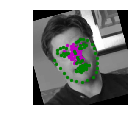

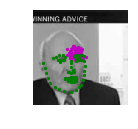

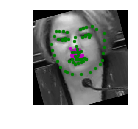

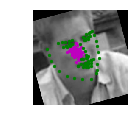

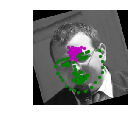

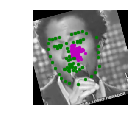

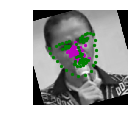

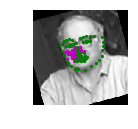

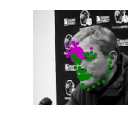

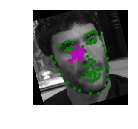

In [13]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.detach().cpu().numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.detach().cpu().numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [14]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(net.parameters(),lr=0.0001, betas=(0.9, 0.999))


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [15]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()
    loss_over_time=[]

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']
            
            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            if train_on_gpu:
                images = images.type(torch.cuda.FloatTensor)
                key_pts = key_pts.type(torch.cuda.FloatTensor)
            else:
                key_pts = key_pts.type(torch.FloatTensor)
                images = images.type(torch.FloatTensor)
            
            images.to(device)
            key_pts.to(device)
            

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()
                     

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                loss_over_time.append(running_loss/10)
                running_loss = 0.0
                
                

    print('Finished Training')
    return loss_over_time

In [16]:
# train your network
n_epochs = 15 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    training_loss=train_net(n_epochs)

/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.24425254464149476
Epoch: 1, Batch: 20, Avg. Loss: 0.18428119421005248
Epoch: 1, Batch: 30, Avg. Loss: 0.16838201582431794
Epoch: 1, Batch: 40, Avg. Loss: 0.14665146097540854
Epoch: 1, Batch: 50, Avg. Loss: 0.14510323256254196
Epoch: 1, Batch: 60, Avg. Loss: 0.13144198432564735
Epoch: 1, Batch: 70, Avg. Loss: 0.12531531304121019
Epoch: 1, Batch: 80, Avg. Loss: 0.11486610770225525
Epoch: 1, Batch: 90, Avg. Loss: 0.13135651051998137
Epoch: 1, Batch: 100, Avg. Loss: 0.11779040768742562
Epoch: 1, Batch: 110, Avg. Loss: 0.13296024426817893
Epoch: 1, Batch: 120, Avg. Loss: 0.12552426755428314
Epoch: 1, Batch: 130, Avg. Loss: 0.11487851217389107
Epoch: 1, Batch: 140, Avg. Loss: 0.13381049335002898
Epoch: 1, Batch: 150, Avg. Loss: 0.12165823429822922
Epoch: 1, Batch: 160, Avg. Loss: 0.1166915699839592
Epoch: 1, Batch: 170, Avg. Loss: 0.13102945908904076
Epoch: 1, Batch: 180, Avg. Loss: 0.12769662514328955
Epoch: 1, Batch: 190, Avg. Loss: 0.10801557824015617
Epo

/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.10380010530352593
Epoch: 2, Batch: 20, Avg. Loss: 0.09665390774607659
Epoch: 2, Batch: 30, Avg. Loss: 0.08908669464290142
Epoch: 2, Batch: 40, Avg. Loss: 0.12898326739668847
Epoch: 2, Batch: 50, Avg. Loss: 0.09545152485370637
Epoch: 2, Batch: 60, Avg. Loss: 0.11221245564520359
Epoch: 2, Batch: 70, Avg. Loss: 0.0977368824183941
Epoch: 2, Batch: 80, Avg. Loss: 0.09882284477353095
Epoch: 2, Batch: 90, Avg. Loss: 0.11776174530386925
Epoch: 2, Batch: 100, Avg. Loss: 0.09191139936447143
Epoch: 2, Batch: 110, Avg. Loss: 0.09330763071775436
Epoch: 2, Batch: 120, Avg. Loss: 0.10490286834537983
Epoch: 2, Batch: 130, Avg. Loss: 0.09130806028842926
Epoch: 2, Batch: 140, Avg. Loss: 0.1054284106940031
Epoch: 2, Batch: 150, Avg. Loss: 0.11078492254018783
Epoch: 2, Batch: 160, Avg. Loss: 0.09527905583381653
Epoch: 2, Batch: 170, Avg. Loss: 0.11226176172494888
Epoch: 2, Batch: 180, Avg. Loss: 0.10401726886630058
Epoch: 2, Batch: 190, Avg. Loss: 0.0913824986666441
Epoch

/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.07993193194270135
Epoch: 3, Batch: 20, Avg. Loss: 0.09978820979595185
Epoch: 3, Batch: 30, Avg. Loss: 0.09211284182965755
Epoch: 3, Batch: 40, Avg. Loss: 0.08312646001577377
Epoch: 3, Batch: 50, Avg. Loss: 0.08654876463115216
Epoch: 3, Batch: 60, Avg. Loss: 0.08052911050617695
Epoch: 3, Batch: 70, Avg. Loss: 0.08236069567501544
Epoch: 3, Batch: 80, Avg. Loss: 0.1003391608595848
Epoch: 3, Batch: 90, Avg. Loss: 0.09561834670603275
Epoch: 3, Batch: 100, Avg. Loss: 0.10059782452881336
Epoch: 3, Batch: 110, Avg. Loss: 0.10213716179132462
Epoch: 3, Batch: 120, Avg. Loss: 0.07926632985472679
Epoch: 3, Batch: 130, Avg. Loss: 0.08345572352409363
Epoch: 3, Batch: 140, Avg. Loss: 0.07897778488695621
Epoch: 3, Batch: 150, Avg. Loss: 0.07898011319339275
Epoch: 3, Batch: 160, Avg. Loss: 0.0874987080693245
Epoch: 3, Batch: 170, Avg. Loss: 0.1165970467031002
Epoch: 3, Batch: 180, Avg. Loss: 0.08830362670123577
Epoch: 3, Batch: 190, Avg. Loss: 0.09129118174314499
Epoch

/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.0773706503212452
Epoch: 4, Batch: 20, Avg. Loss: 0.08062359876930714
Epoch: 4, Batch: 30, Avg. Loss: 0.0850968599319458
Epoch: 4, Batch: 40, Avg. Loss: 0.09495186097919942
Epoch: 4, Batch: 50, Avg. Loss: 0.09163682162761688
Epoch: 4, Batch: 60, Avg. Loss: 0.0782300129532814
Epoch: 4, Batch: 70, Avg. Loss: 0.07519265078008175
Epoch: 4, Batch: 80, Avg. Loss: 0.07895888723433017
Epoch: 4, Batch: 90, Avg. Loss: 0.08817073255777359
Epoch: 4, Batch: 100, Avg. Loss: 0.07516651824116707
Epoch: 4, Batch: 110, Avg. Loss: 0.08693456873297692
Epoch: 4, Batch: 120, Avg. Loss: 0.08646497875452042
Epoch: 4, Batch: 130, Avg. Loss: 0.07268637455999852
Epoch: 4, Batch: 140, Avg. Loss: 0.07208940871059895
Epoch: 4, Batch: 150, Avg. Loss: 0.07054510414600372
Epoch: 4, Batch: 160, Avg. Loss: 0.08474258296191692
Epoch: 4, Batch: 170, Avg. Loss: 0.08698762841522693
Epoch: 4, Batch: 180, Avg. Loss: 0.09491658806800843
Epoch: 4, Batch: 190, Avg. Loss: 0.08711671605706214
Epoch

/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.07290832996368408
Epoch: 5, Batch: 20, Avg. Loss: 0.07368755005300046
Epoch: 5, Batch: 30, Avg. Loss: 0.06662262938916683
Epoch: 5, Batch: 40, Avg. Loss: 0.06935013383626938
Epoch: 5, Batch: 50, Avg. Loss: 0.09100873582065105
Epoch: 5, Batch: 60, Avg. Loss: 0.0711919404566288
Epoch: 5, Batch: 70, Avg. Loss: 0.08387712389230728
Epoch: 5, Batch: 80, Avg. Loss: 0.08137404844164849
Epoch: 5, Batch: 90, Avg. Loss: 0.08760312609374524
Epoch: 5, Batch: 100, Avg. Loss: 0.06584420315921306
Epoch: 5, Batch: 110, Avg. Loss: 0.09517955668270588
Epoch: 5, Batch: 120, Avg. Loss: 0.07380544915795326
Epoch: 5, Batch: 130, Avg. Loss: 0.07824306413531304
Epoch: 5, Batch: 140, Avg. Loss: 0.06372228413820266
Epoch: 5, Batch: 150, Avg. Loss: 0.07620234042406082
Epoch: 5, Batch: 160, Avg. Loss: 0.06229768544435501
Epoch: 5, Batch: 170, Avg. Loss: 0.07951757423579693
Epoch: 5, Batch: 180, Avg. Loss: 0.0679219413548708
Epoch: 5, Batch: 190, Avg. Loss: 0.08046683259308338
Epoc

/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.06983395516872407
Epoch: 6, Batch: 20, Avg. Loss: 0.05227242037653923
Epoch: 6, Batch: 30, Avg. Loss: 0.0706065434962511
Epoch: 6, Batch: 40, Avg. Loss: 0.08464307263493538
Epoch: 6, Batch: 50, Avg. Loss: 0.08277344815433026
Epoch: 6, Batch: 60, Avg. Loss: 0.06153329685330391
Epoch: 6, Batch: 70, Avg. Loss: 0.07925964556634427
Epoch: 6, Batch: 80, Avg. Loss: 0.06652578730136156
Epoch: 6, Batch: 90, Avg. Loss: 0.07067156657576561
Epoch: 6, Batch: 100, Avg. Loss: 0.06884624846279622
Epoch: 6, Batch: 110, Avg. Loss: 0.06852245591580867
Epoch: 6, Batch: 120, Avg. Loss: 0.06306939944624901
Epoch: 6, Batch: 130, Avg. Loss: 0.06376204043626785
Epoch: 6, Batch: 140, Avg. Loss: 0.07279573194682598
Epoch: 6, Batch: 150, Avg. Loss: 0.05398237891495228
Epoch: 6, Batch: 160, Avg. Loss: 0.06987413093447685
Epoch: 6, Batch: 170, Avg. Loss: 0.0663602165877819
Epoch: 6, Batch: 180, Avg. Loss: 0.08464239351451397
Epoch: 6, Batch: 190, Avg. Loss: 0.0758843444287777
Epoch

/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.07045566961169243
Epoch: 7, Batch: 20, Avg. Loss: 0.07395520955324172
Epoch: 7, Batch: 30, Avg. Loss: 0.06846324428915977
Epoch: 7, Batch: 40, Avg. Loss: 0.07064130827784539
Epoch: 7, Batch: 50, Avg. Loss: 0.05692935883998871
Epoch: 7, Batch: 60, Avg. Loss: 0.08099070526659488
Epoch: 7, Batch: 70, Avg. Loss: 0.0680731225758791
Epoch: 7, Batch: 80, Avg. Loss: 0.06628976464271545
Epoch: 7, Batch: 90, Avg. Loss: 0.046161384880542757
Epoch: 7, Batch: 100, Avg. Loss: 0.07306313477456569
Epoch: 7, Batch: 110, Avg. Loss: 0.05501392297446728
Epoch: 7, Batch: 120, Avg. Loss: 0.06713547296822071
Epoch: 7, Batch: 130, Avg. Loss: 0.06735566705465316
Epoch: 7, Batch: 140, Avg. Loss: 0.05933782495558262
Epoch: 7, Batch: 150, Avg. Loss: 0.07234676480293274
Epoch: 7, Batch: 160, Avg. Loss: 0.06623631604015827
Epoch: 7, Batch: 170, Avg. Loss: 0.0568245068192482
Epoch: 7, Batch: 180, Avg. Loss: 0.07174991145730018
Epoch: 7, Batch: 190, Avg. Loss: 0.051848190277814864
Ep

/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.06747377216815949
Epoch: 8, Batch: 20, Avg. Loss: 0.055465462245047094
Epoch: 8, Batch: 30, Avg. Loss: 0.07467033304274082
Epoch: 8, Batch: 40, Avg. Loss: 0.07163186520338058
Epoch: 8, Batch: 50, Avg. Loss: 0.06269819103181362
Epoch: 8, Batch: 60, Avg. Loss: 0.06414125449955463
Epoch: 8, Batch: 70, Avg. Loss: 0.06005641296505928
Epoch: 8, Batch: 80, Avg. Loss: 0.06261154897511005
Epoch: 8, Batch: 90, Avg. Loss: 0.05095662027597427
Epoch: 8, Batch: 100, Avg. Loss: 0.05769359357655048
Epoch: 8, Batch: 110, Avg. Loss: 0.059875956177711485
Epoch: 8, Batch: 120, Avg. Loss: 0.05329359732568264
Epoch: 8, Batch: 130, Avg. Loss: 0.05700404476374388
Epoch: 8, Batch: 140, Avg. Loss: 0.04843408074229956
Epoch: 8, Batch: 150, Avg. Loss: 0.05102312155067921
Epoch: 8, Batch: 160, Avg. Loss: 0.04018368925899267
Epoch: 8, Batch: 170, Avg. Loss: 0.04404774401336908
Epoch: 8, Batch: 180, Avg. Loss: 0.05802655965089798
Epoch: 8, Batch: 190, Avg. Loss: 0.062177344039082524

/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.06940516270697117
Epoch: 9, Batch: 20, Avg. Loss: 0.06062024421989918
Epoch: 9, Batch: 30, Avg. Loss: 0.05991213284432888
Epoch: 9, Batch: 40, Avg. Loss: 0.06517853569239378
Epoch: 9, Batch: 50, Avg. Loss: 0.05128939934074879
Epoch: 9, Batch: 60, Avg. Loss: 0.05232118889689445
Epoch: 9, Batch: 70, Avg. Loss: 0.08316727466881275
Epoch: 9, Batch: 80, Avg. Loss: 0.049382807686924934
Epoch: 9, Batch: 90, Avg. Loss: 0.04239396099001169
Epoch: 9, Batch: 100, Avg. Loss: 0.06455997172743082
Epoch: 9, Batch: 110, Avg. Loss: 0.049787957966327664
Epoch: 9, Batch: 120, Avg. Loss: 0.05847023874521255
Epoch: 9, Batch: 130, Avg. Loss: 0.06994478106498718
Epoch: 9, Batch: 140, Avg. Loss: 0.03869674000889063
Epoch: 9, Batch: 150, Avg. Loss: 0.0641551997512579
Epoch: 9, Batch: 160, Avg. Loss: 0.061540568992495534
Epoch: 9, Batch: 170, Avg. Loss: 0.05502855069935322
Epoch: 9, Batch: 180, Avg. Loss: 0.06283044666051865
Epoch: 9, Batch: 190, Avg. Loss: 0.05839514508843422


/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.04517424814403057
Epoch: 10, Batch: 20, Avg. Loss: 0.05523480661213398
Epoch: 10, Batch: 30, Avg. Loss: 0.04197405222803354
Epoch: 10, Batch: 40, Avg. Loss: 0.0642877297475934
Epoch: 10, Batch: 50, Avg. Loss: 0.06077978871762753
Epoch: 10, Batch: 60, Avg. Loss: 0.04057190250605345
Epoch: 10, Batch: 70, Avg. Loss: 0.051467247679829596
Epoch: 10, Batch: 80, Avg. Loss: 0.05781754907220602
Epoch: 10, Batch: 90, Avg. Loss: 0.05181071478873491
Epoch: 10, Batch: 100, Avg. Loss: 0.04868935365229845
Epoch: 10, Batch: 110, Avg. Loss: 0.04353249501436949
Epoch: 10, Batch: 120, Avg. Loss: 0.05028042681515217
Epoch: 10, Batch: 130, Avg. Loss: 0.04940702654421329
Epoch: 10, Batch: 140, Avg. Loss: 0.06809969022870063
Epoch: 10, Batch: 150, Avg. Loss: 0.04620523024350405
Epoch: 10, Batch: 160, Avg. Loss: 0.052188113890588285
Epoch: 10, Batch: 170, Avg. Loss: 0.04523601867258549
Epoch: 10, Batch: 180, Avg. Loss: 0.04125784281641245
Epoch: 10, Batch: 190, Avg. Loss: 0.

/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 10, Avg. Loss: 0.04569750539958477
Epoch: 11, Batch: 20, Avg. Loss: 0.053374489210546015
Epoch: 11, Batch: 30, Avg. Loss: 0.04390509221702814
Epoch: 11, Batch: 40, Avg. Loss: 0.0540720259770751
Epoch: 11, Batch: 50, Avg. Loss: 0.040111785382032396
Epoch: 11, Batch: 60, Avg. Loss: 0.049189715459942815
Epoch: 11, Batch: 70, Avg. Loss: 0.041729819029569626
Epoch: 11, Batch: 80, Avg. Loss: 0.04717965386807919
Epoch: 11, Batch: 90, Avg. Loss: 0.041582067497074604
Epoch: 11, Batch: 100, Avg. Loss: 0.04435951076447964
Epoch: 11, Batch: 110, Avg. Loss: 0.046183884143829346
Epoch: 11, Batch: 120, Avg. Loss: 0.06305906921625137
Epoch: 11, Batch: 130, Avg. Loss: 0.05868340209126473
Epoch: 11, Batch: 140, Avg. Loss: 0.045701175928115845
Epoch: 11, Batch: 150, Avg. Loss: 0.05777058470994234
Epoch: 11, Batch: 160, Avg. Loss: 0.05561669170856476
Epoch: 11, Batch: 170, Avg. Loss: 0.040472747012972835
Epoch: 11, Batch: 180, Avg. Loss: 0.048499477095901966
Epoch: 11, Batch: 190, Avg. L

/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 10, Avg. Loss: 0.052964354678988454
Epoch: 12, Batch: 20, Avg. Loss: 0.04402012638747692
Epoch: 12, Batch: 30, Avg. Loss: 0.054457294195890425
Epoch: 12, Batch: 40, Avg. Loss: 0.057565704360604285
Epoch: 12, Batch: 50, Avg. Loss: 0.041389557719230655
Epoch: 12, Batch: 60, Avg. Loss: 0.05532156769186258
Epoch: 12, Batch: 70, Avg. Loss: 0.06435968223959207
Epoch: 12, Batch: 80, Avg. Loss: 0.05056958366185427
Epoch: 12, Batch: 90, Avg. Loss: 0.04171382412314415
Epoch: 12, Batch: 100, Avg. Loss: 0.038446467742323874
Epoch: 12, Batch: 110, Avg. Loss: 0.03308138288557529
Epoch: 12, Batch: 120, Avg. Loss: 0.051531923562288286
Epoch: 12, Batch: 130, Avg. Loss: 0.05986125152558088
Epoch: 12, Batch: 140, Avg. Loss: 0.051179394498467444
Epoch: 12, Batch: 150, Avg. Loss: 0.04182463269680738
Epoch: 12, Batch: 160, Avg. Loss: 0.04609311018139124
Epoch: 12, Batch: 170, Avg. Loss: 0.04435081947594881
Epoch: 12, Batch: 180, Avg. Loss: 0.0510546850040555
Epoch: 12, Batch: 190, Avg. Los

/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 10, Avg. Loss: 0.03646120820194483
Epoch: 13, Batch: 20, Avg. Loss: 0.05118274558335543
Epoch: 13, Batch: 30, Avg. Loss: 0.04422525018453598
Epoch: 13, Batch: 40, Avg. Loss: 0.04960760623216629
Epoch: 13, Batch: 50, Avg. Loss: 0.061969942040741445
Epoch: 13, Batch: 60, Avg. Loss: 0.04854504354298115
Epoch: 13, Batch: 70, Avg. Loss: 0.04849668387323618
Epoch: 13, Batch: 80, Avg. Loss: 0.042150558531284334
Epoch: 13, Batch: 90, Avg. Loss: 0.04469862803816795
Epoch: 13, Batch: 100, Avg. Loss: 0.04353601168841124
Epoch: 13, Batch: 110, Avg. Loss: 0.04602204710245132
Epoch: 13, Batch: 120, Avg. Loss: 0.050613930076360704
Epoch: 13, Batch: 130, Avg. Loss: 0.05546327121555805
Epoch: 13, Batch: 140, Avg. Loss: 0.0420010918751359
Epoch: 13, Batch: 150, Avg. Loss: 0.052021441794931886
Epoch: 13, Batch: 160, Avg. Loss: 0.04317216705530882
Epoch: 13, Batch: 170, Avg. Loss: 0.049164405651390554
Epoch: 13, Batch: 180, Avg. Loss: 0.06989724487066269
Epoch: 13, Batch: 190, Avg. Loss:

/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 10, Avg. Loss: 0.05449739582836628
Epoch: 14, Batch: 20, Avg. Loss: 0.04863346349447965
Epoch: 14, Batch: 30, Avg. Loss: 0.04614473450928926
Epoch: 14, Batch: 40, Avg. Loss: 0.05246098507195711
Epoch: 14, Batch: 50, Avg. Loss: 0.03656441569328308
Epoch: 14, Batch: 60, Avg. Loss: 0.03587366752326489
Epoch: 14, Batch: 70, Avg. Loss: 0.04619269445538521
Epoch: 14, Batch: 80, Avg. Loss: 0.04225757960230112
Epoch: 14, Batch: 90, Avg. Loss: 0.04310813434422016
Epoch: 14, Batch: 100, Avg. Loss: 0.049966559186577796
Epoch: 14, Batch: 110, Avg. Loss: 0.04388757403939962
Epoch: 14, Batch: 120, Avg. Loss: 0.05825482811778784
Epoch: 14, Batch: 130, Avg. Loss: 0.042261162772774696
Epoch: 14, Batch: 140, Avg. Loss: 0.04782992601394653
Epoch: 14, Batch: 150, Avg. Loss: 0.03857714701443911
Epoch: 14, Batch: 160, Avg. Loss: 0.04963243305683136
Epoch: 14, Batch: 170, Avg. Loss: 0.04722115118056536
Epoch: 14, Batch: 180, Avg. Loss: 0.056120843067765235
Epoch: 14, Batch: 190, Avg. Loss: 

/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 10, Avg. Loss: 0.052192282490432264
Epoch: 15, Batch: 20, Avg. Loss: 0.035482790879905225
Epoch: 15, Batch: 30, Avg. Loss: 0.043638347275555135
Epoch: 15, Batch: 40, Avg. Loss: 0.05245982352644205
Epoch: 15, Batch: 50, Avg. Loss: 0.05419770069420338
Epoch: 15, Batch: 60, Avg. Loss: 0.04220010843127966
Epoch: 15, Batch: 70, Avg. Loss: 0.04394352920353413
Epoch: 15, Batch: 80, Avg. Loss: 0.040751416608691214
Epoch: 15, Batch: 90, Avg. Loss: 0.04478917494416237
Epoch: 15, Batch: 100, Avg. Loss: 0.055812735296785834
Epoch: 15, Batch: 110, Avg. Loss: 0.046571162343025205
Epoch: 15, Batch: 120, Avg. Loss: 0.050051015056669715
Epoch: 15, Batch: 130, Avg. Loss: 0.04231545440852642
Epoch: 15, Batch: 140, Avg. Loss: 0.03620736226439476
Epoch: 15, Batch: 150, Avg. Loss: 0.04907362051308155
Epoch: 15, Batch: 160, Avg. Loss: 0.08003597408533096
Epoch: 15, Batch: 170, Avg. Loss: 0.0418120514601469
Epoch: 15, Batch: 180, Avg. Loss: 0.051101168245077135
Epoch: 15, Batch: 190, Avg. Lo

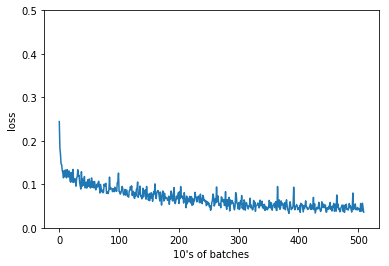

In [17]:
# visualize the loss as the network trained
plt.plot(training_loss)
plt.xlabel('10\'s of batches')
plt.ylabel('loss')
plt.ylim(0, .5) # consistent scale
plt.show()

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [18]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


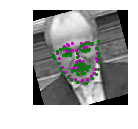

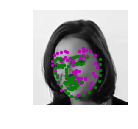

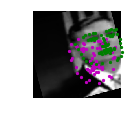

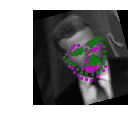

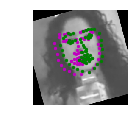

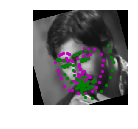

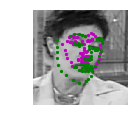

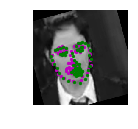

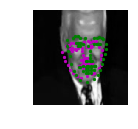

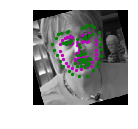

In [19]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [20]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: 
Since this is a regression problem and we need to directly find the difference between the actual values and predicted values of the keypoints, i have chosen the SmoothL1Loss. As compared to MSEloss, SmoothL1 converges faster

And I have chosen the Adam optimiser with parameters as was mentioned in the paper - Facial Key Points Detection using Deep
Convolutional Neural Network - NaimishNet

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: 
i started with 2 conv layers and then added one layer at a time. Taking a hint from the paper, i added 4 conv layers.

To avoid overfitting of data, i added the 
1. Dropout layers for the linear layers and
2. Batch Norm layers for the conv layers.

However, BatchNorm made the whole process of convergence very slow and hence i removed them.



### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**:

i initially trained for 1/2 epochs (1 for lower batch size and 2 for higher batch size) to study the loss pattern - the inital loss value and how it was gradually decreasing. 
once i was satisfied with the model, i next increased the number of epochs to 10, then 15

i modified the code to work with CUDA so i could take advantage of batchsizes as multiples of 2. increasing to even 16/32(more than the initial value of 10) caused OOM errors.
However, i noticed that the batch size of 10 gave better results than the batchsizes of 16/32



## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.09867535  0.05775272 -0.05444649 -0.03789001]
 [-0.09283833 -0.10262165 -0.08935261  0.02507572]
 [-0.06607032  0.07285859 -0.00712978 -0.05487172]
 [ 0.09910977  0.07637624  0.02105818 -0.08932523]]
(4, 4)


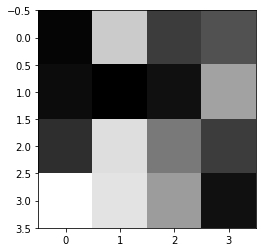

In [21]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.detach().cpu().numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

In [22]:
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'
net = Net()
net.load_state_dict(torch.load(model_dir+model_name,map_location=lambda storage, loc: storage))

Text(0.5,1,'filtered')

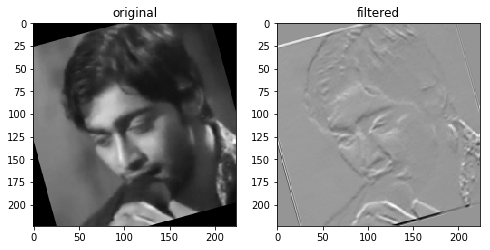

In [32]:
##TODO: load in and display any image from the transformed test dataset
import cv2

image = test_images[5].data   # get the image from it's Variable wrapper
image = image.detach().cpu().numpy()   # convert to numpy array from a Tensor
image = np.squeeze(np.transpose(image, (1, 2, 0)) )  # transpose to go from torch to numpy image

weights1 = net.conv1.weight.data
w = weights1.detach().cpu().numpy()
filter_index = 30

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
filtered_image = cv2.filter2D(image, -1, w[filter_index][0])


fig, (ax1, ax2) = plt.subplots(figsize=(8,8), nrows=1, ncols=2)
ax1.imshow(image,cmap='gray')
ax1.set_title('original')
ax2.imshow(filtered_image,cmap='gray')
ax2.set_title('filtered')




### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: (does it detect vertical lines or does it blur out noise, etc.) write your answer here

I chose the first filter from conv1. This seems to detect edges. 

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!